In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Replace the path the actual folder name
os.chdir('/content/drive/MyDrive/fraud')

# Confirm that the files are accessible
os.listdir()

['creditcard.csv', 'Euniee.ipynb', 'Euniee- XGboost.ipynb']

In [ ]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# prompt: Split Train/Test Sets

# Splitting the data into training and testing sets
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# prompt: train an XGBoost classifier with cross-validation

import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring='roc_auc') # Using roc_auc as a metric

# Print the cross-validation scores
print("Cross-validation ROC AUC scores:", cv_scores)
print("Mean ROC AUC score:", np.mean(cv_scores))
print("Standard deviation of ROC AUC score:", np.std(cv_scores))

# Train the model on the entire training set (after cross-validation)
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


Cross-validation ROC AUC scores: [0.97924526 0.96992217 0.97013282 0.99268194 0.982131  ]
Mean ROC AUC score: 0.9788226365387442
Standard deviation of ROC AUC score: 0.008460914501520011
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.78      0.86        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



Area Under the Precision-Recall Curve (AUPRC): 0.8776143513157532


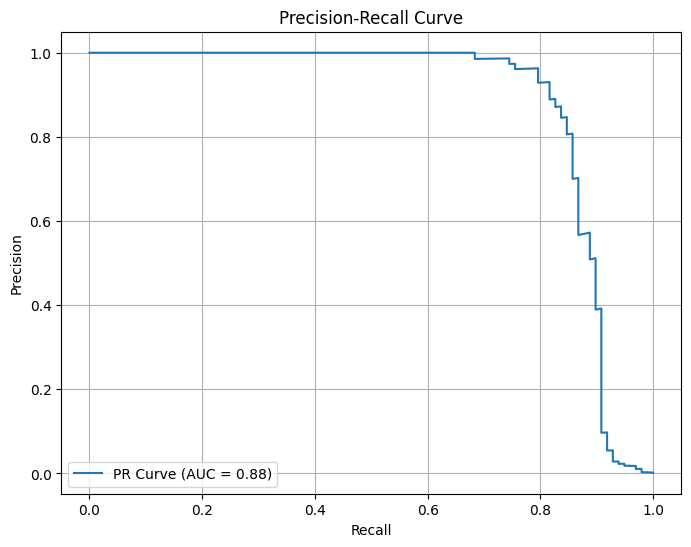

In [ ]:
# prompt: give Accuracy, Precision, Recall, F-1 score, PR Curves for xgb_classifier

from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# ... (Your existing code) ...

# Predict probabilities for the positive class
y_prob = xgb_classifier.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Calculate the area under the PR curve (AUPRC)
pr_auc = auc(recall, precision)


# Print the AUPRC
print(f"Area Under the Precision-Recall Curve (AUPRC): {pr_auc}")

# Plot the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


Original dataset shape Counter({0: 227451, 1: 394})
Resampled dataset shape Counter({0: 227451, 1: 227451})
Cross-validation ROC AUC scores: [0.99998042 0.99999859 0.99999648 0.99999025 0.99999571]
Mean ROC AUC score: 0.9999922882135218
Standard deviation of ROC AUC score: 6.541022728286488e-06
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.86      0.83        98

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Area Under the Precision-Recall Curve (AUPRC): 0.8773022180394816


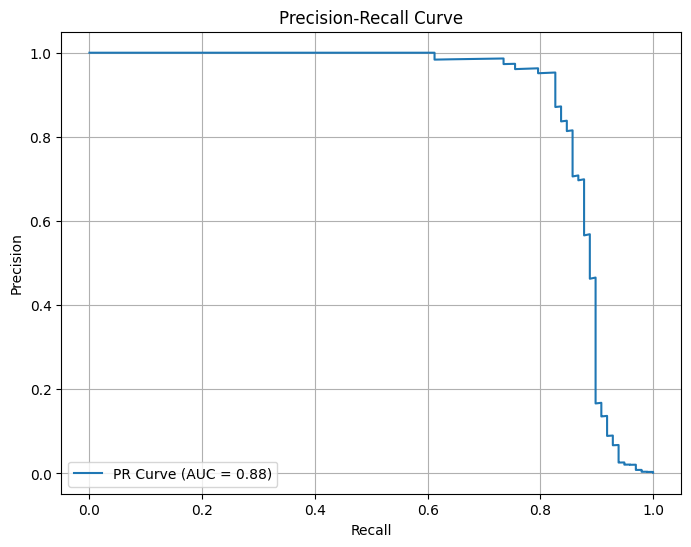

In [ ]:
# prompt: train an XGBoost  with cross-validation and smote to deal inbalance data

import matplotlib.pyplot as plt
import numpy as np
# ... (Your existing code) ...

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original dataset shape %s" % Counter(y_train))
print("Resampled dataset shape %s" % Counter(y_train_resampled))

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Perform cross-validation on the resampled data
cv_scores = cross_val_score(xgb_classifier, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')

# Print the cross-validation scores
print("Cross-validation ROC AUC scores:", cv_scores)
print("Mean ROC AUC score:", np.mean(cv_scores))
print("Standard deviation of ROC AUC score:", np.std(cv_scores))

# Train the model on the entire resampled training set
xgb_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Predict probabilities for the positive class
y_prob = xgb_classifier.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Calculate the area under the PR curve (AUPRC)
pr_auc = auc(recall, precision)

# Print the AUPRC
print(f"Area Under the Precision-Recall Curve (AUPRC): {pr_auc}")

# Plot the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


111111111

In [ ]:
# prompt: train xgboost model

!pip install xgboost
import xgboost as xgb

# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, xgb_predictions))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.78      0.86        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
# prompt: Evaluate the Model
# Use metrics that reflect fraud detection performance:

from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Assuming xgb_predictions and y_test are already defined from your previous code

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, xgb_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Accuracy
accuracy = accuracy_score(y_test, xgb_predictions)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_test, xgb_predictions)
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, xgb_predictions)
print(f"Recall: {recall}")

# F1-score
f1 = f1_score(y_test, xgb_predictions)
print(f"F1-score: {f1}")

# ROC AUC Score
roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score: {roc_auc}")


Confusion Matrix:
 [[56861     3]
 [   22    76]]
Accuracy: 0.9995611109160493
Precision: 0.9620253164556962
Recall: 0.7755102040816326
F1-score: 0.8587570621468926
ROC AUC Score: 0.9811164195560047


Confusion Matrix:
 [[56861     3]
 [   22    76]]


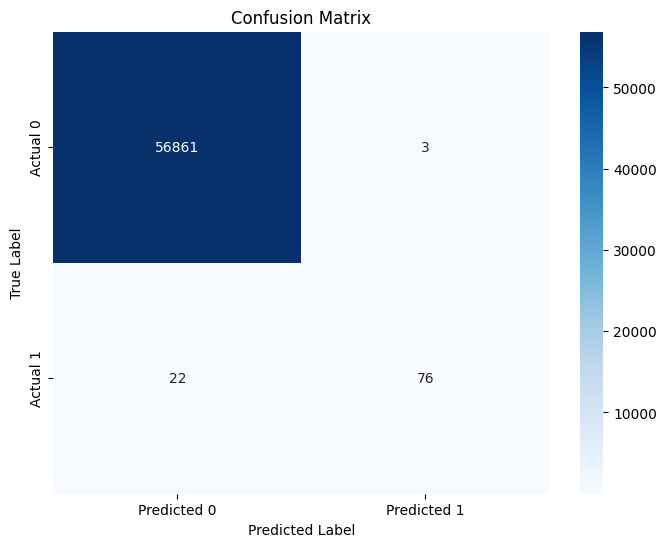

In [ ]:
# prompt: visualzie confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns

# ... (your existing code) ...

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, xgb_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ... (rest of your evaluation code) ...


In [ ]:
# prompt: now  Run Hyperparameter Tuning with xgboost to improve our model

from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),  # use_label_encoder=False for newer xgboost versions
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='roc_auc',  # Use ROC AUC as the evaluation metric
    n_jobs=-1,  # Use all available cores
    cv=3,  # Number of cross-validation folds
    verbose=2,  # Print progress updates
    random_state=42
)


# Fit the randomized search to the data
random_search.fit(X_train, y_train)


# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best ROC AUC Score: {best_score}")

# Train a model with the best parameters
best_xgb_model = xgb.XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')
best_xgb_model.fit(X_train, y_train)

# Make predictions with the best model
best_xgb_predictions = best_xgb_model.predict(X_test)


# Evaluate the best model
print(classification_report(y_test, best_xgb_predictions))

# ... (rest of your evaluation code, using best_xgb_model and best_xgb_predictions) ...



Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:16:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Best ROC AUC Score: 0.9845167976956434


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:16:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.80      0.88        98

    accuracy                           1.00     56962
   macro avg       0.99      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
# Calculate and print individual metrics
accuracy = accuracy_score(y_test, best_xgb_predictions)
print(f"Accuracy: {accuracy}")
precision = precision_score(y_test, best_xgb_predictions)
print(f"Precision: {precision}")
recall = recall_score(y_test, best_xgb_predictions)
print(f"Recall: {recall}")
f1 = f1_score(y_test, best_xgb_predictions)
print(f"F1-score: {f1}")
roc_auc = roc_auc_score(y_test, best_xgb_model.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score: {roc_auc}")

Accuracy: 0.9996137776061234
Precision: 0.975
Recall: 0.7959183673469388
F1-score: 0.8764044943820225
ROC AUC Score: 0.9842413118877265


In [ ]:
# prompt: try to imporve recall with XGboost and smote

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize and train the XGBoost model with the resampled data
xgb_model_smote = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model_smote.fit(X_train_resampled, y_train_resampled)

# Make predictions
xgb_predictions_smote = xgb_model_smote.predict(X_test)

# Evaluate the model
print(classification_report(y_test, xgb_predictions_smote))

# Calculate and print individual metrics for SMOTE model
accuracy_smote = accuracy_score(y_test, xgb_predictions_smote)
print(f"Accuracy (SMOTE): {accuracy_smote}")
precision_smote = precision_score(y_test, xgb_predictions_smote)
print(f"Precision (SMOTE): {precision_smote}")
recall_smote = recall_score(y_test, xgb_predictions_smote)
print(f"Recall (SMOTE): {recall_smote}")
f1_smote = f1_score(y_test, xgb_predictions_smote)
print(f"F1-score (SMOTE): {f1_smote}")
roc_auc_smote = roc_auc_score(y_test, xgb_model_smote.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score (SMOTE): {roc_auc_smote}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:17:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.86      0.83        98

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy (SMOTE): 0.999385555282469
Precision (SMOTE): 0.8
Recall (SMOTE): 0.8571428571428571
F1-score (SMOTE): 0.8275862068965517
ROC AUC Score (SMOTE): 0.9859896652808563


In [ ]:
# prompt: smote+xgboost +  Run Hyperparameter Tuning

# ... (your existing code) ...
from sklearn.model_selection import RandomizedSearchCV # Import the RandomizedSearchCV class

# Define the parameter grid for SMOTE + XGBoost
param_grid_smote = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Initialize RandomizedSearchCV for SMOTE + XGBoost
random_search_smote = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_distributions=param_grid_smote,
    n_iter=10,
    scoring='roc_auc',
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42
)

# Fit the randomized search to the resampled data
random_search_smote.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and best score for SMOTE + XGBoost
best_params_smote = random_search_smote.best_params_
best_score_smote = random_search_smote.best_score_

print(f"Best Parameters (SMOTE): {best_params_smote}")
print(f"Best ROC AUC Score (SMOTE): {best_score_smote}")

# Train a model with the best parameters for SMOTE + XGBoost
best_xgb_model_smote = xgb.XGBClassifier(**best_params_smote, random_state=42, use_label_encoder=False, eval_metric='logloss')
best_xgb_model_smote.fit(X_train_resampled, y_train_resampled)

# Make predictions with the best SMOTE model
best_xgb_predictions_smote = best_xgb_model_smote.predict(X_test)

# Evaluate the best SMOTE model
print(classification_report(y_test, best_xgb_predictions_smote))

# ... (rest of your evaluation code, using best_xgb_model_smote and best_xgb_predictions_smote) ...


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:06:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters (SMOTE): {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best ROC AUC Score (SMOTE): 0.999995023558743


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:06:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.85      0.85        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
# prompt: compare precision, recall, roc etc for xgboost model, xgboost with smote only, xgboost with Hyperparameter Tuning, and xgboost with smote and Hyperparameter Tuning
import xgboost as xgb
import pandas as pd
# ... (your existing code) ...

# Function to evaluate and print metrics
def evaluate_model(model, predictions, model_name):
    print(f"\n--- {model_name} ---")
    print(classification_report(y_test, predictions))
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy}")
    precision = precision_score(y_test, predictions)
    print(f"Precision: {precision}")
    recall = recall_score(y_test, predictions)
    print(f"Recall: {recall}")
    f1 = f1_score(y_test, predictions)
    print(f"F1-score: {f1}")
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"ROC AUC Score: {roc_auc}")
    return accuracy, precision, recall, f1, roc_auc


# Evaluate the models
metrics = {}
metrics["XGBoost"] = evaluate_model(xgb_model, xgb_predictions, "XGBoost")
metrics["XGBoost with SMOTE"] = evaluate_model(xgb_model_smote, xgb_predictions_smote, "XGBoost with SMOTE")
metrics["XGBoost with Hyperparameter Tuning"] = evaluate_model(best_xgb_model, best_xgb_predictions, "XGBoost with Hyperparameter Tuning")
metrics["XGBoost with SMOTE and Hyperparameter Tuning"] = evaluate_model(best_xgb_model_smote, best_xgb_predictions_smote, "XGBoost with SMOTE and Hyperparameter Tuning")


# Create a DataFrame for easy comparison
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC'])
print("\n--- Metrics Comparison ---")
metrics_df



--- XGBoost ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.78      0.86        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9995611109160493
Precision: 0.9620253164556962
Recall: 0.7755102040816326
F1-score: 0.8587570621468926
ROC AUC Score: 0.9811164195560047

--- XGBoost with SMOTE ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.86      0.83        98

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.999385555282469
Precision: 0.8
Recall: 0.8571428571428571
F1-score: 0.8275862068965517
ROC AUC Score: 0.9859896652808563

--- XGBoost with H

,Accuracy,Precision,Recall,F1-score,ROC AUC
XGBoost,0.999561,0.962025,0.775510,0.858757,0.981116
XGBoost with SMOTE,0.999386,0.800000,0.857143,0.827586,0.985990
XGBoost with Hyperparameter Tuning,0.999614,0.975000,0.795918,0.876404,0.984241
XGBoost with SMOTE and Hyperparameter Tuning,0.999491,0.855670,0.846939,0.851282,0.986881


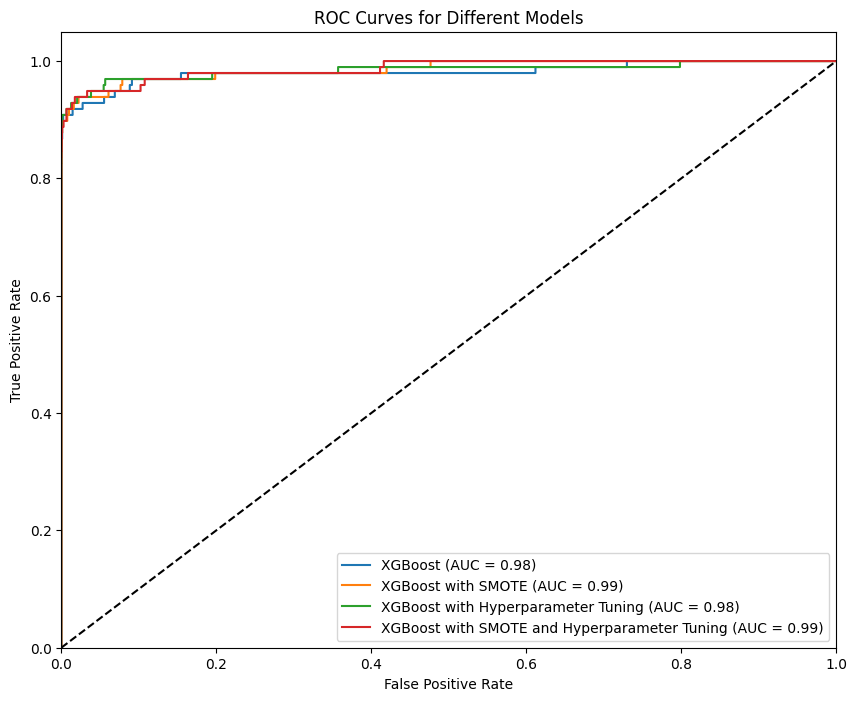

In [ ]:
# prompt: give me roc auc curve for 4 differnet model

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have already trained your models (xgb_model, xgb_model_smote, best_xgb_model, best_xgb_model_smote) and made predictions

models = {
    "XGBoost": xgb_model,
    "XGBoost with SMOTE": xgb_model_smote,
    "XGBoost with Hyperparameter Tuning": best_xgb_model,
    "XGBoost with SMOTE and Hyperparameter Tuning": best_xgb_model_smote
}

plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc="lower right")
plt.show()
